In [1]:
(ns ch7.nb
    (:require [clojupyter.misc.helper :as helper]
              [clojupyter.misc.display :as display]
              [clojure.java.io :as io]
              [incanter.charts :as c]
              [incanter.core :as i]
              [incanter.datasets :as d]
              [incanter.stats :as s]
              [incanter.io :as iio]
              [clojure.string :as string]
              [medley.core :refer [map-vals]]
              [clojure.string :as str]
              [sparkling.conf :as conf]
              [sparkling.core :as spark]
              [sparkling.debug :as s-dbg]
              [sparkling.destructuring :as s-de]
              [sparkling.kryo :as k]
              [sparkling.scalaInterop :as scala])
    (:import [org.apache.mahout.cf.taste.eval RecommenderBuilder]
             [org.apache.mahout.cf.taste.impl.eval 
                GenericRecommenderIRStatsEvaluator 
                RMSRecommenderEvaluator]
             [org.apache.mahout.cf.taste.impl.model GenericBooleanPrefDataModel]
             [org.apache.mahout.cf.taste.impl.model.file FileDataModel]
             [org.apache.mahout.cf.taste.impl.neighborhood NearestNUserNeighborhood]
             [org.apache.mahout.cf.taste.impl.recommender GenericBooleanPrefUserBasedRecommender 
                GenericUserBasedRecommender]
             [org.apache.mahout.cf.taste.impl.similarity EuclideanDistanceSimilarity 
                TanimotoCoefficientSimilarity 
                SpearmanCorrelationSimilarity 
                PearsonCorrelationSimilarity]
             [com.google.common.hash Hashing]
             [org.apache.spark.api.java JavaRDD]
             [org.apache.spark.mllib.linalg Vector SparseVector]
             [org.apache.spark.mllib.linalg.distributed RowMatrix]
             [org.apache.spark.mllib.recommendation ALS Rating]))

# Data inspection

In [2]:
(->> (io/reader "data/ml-100k/ua.base")
     (line-seq)
     (first))

"1\t1\t5\t874965758"

In [3]:
(->> (io/reader "data/ml-100k/u.item")
     (io/reader)
     (line-seq)
     (first))

"1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0"

# Data parsing

In [2]:
(defn to-long
    [s]
    (Long/parseLong s))

(defn line->rating
    [line]
    (->> (string/split line #"\t")
         (map to-long)
         (zipmap [:user :item :rating])))

(defn load-ratings
    [file]
    (with-open [rdr (io/reader (str "data/ml-100k/" file))]
        (->> (line-seq rdr)
             (map line->rating)
             (into []))))

#'ch7.nb/load-ratings

In [5]:
(->> (load-ratings "ua.base")
     (first))

{:user 1, :item 1, :rating 5}

In [12]:
(defn line->item-tuple
    [line]
    (let [[id name] (string/split line #"\|")]
        (vector (to-long id) name)))

(defn load-items
    [path]
    (with-open [rdr (io/reader (str "data/ml-100k/" path))]
        (->> (line-seq rdr)
             (map line->item-tuple)
             (into {}))))

#'ch7.nb/load-items

In [7]:
(-> (load-items "u.item")
    (get 1))

"Toy Story (1995)"

# Recommender Systems

## Slope one

**Slope One** recommenders are a family of algos, we'll use the weighted version [Original paper](http://lemire.me/fr/abstracts/SDM2005.html).

### Difference

We have to start by calculating the average difference between every item

In [8]:
(defn conj-item-difference
    [dict [i j]]
    (let [difference (- (:rating j) (:rating i))]
        (update-in dict [(:item i) (:item j)] conj difference)))

(defn collect-item-differences
    [dict items]
    (reduce conj-item-difference dict
            (for [i items
                  j items
                  :when (not= i j)]
                [i j])))

(defn item-differences
    [user-ratings]
    (reduce collect-item-differences {} user-ratings))

#'ch7.nb/item-differences

In [9]:
(->> (load-ratings "ua.base")
     (group-by :user)
     (vals)
     (item-differences)
     (first))

[893 {558 (-2 4), 453 (-1), 637 (-1), 519 (2), 1244 (0), 1097 (3), 357 (-1 0 3), 716 (1), 275 (1 0), 530 (2), 929 (0), 789 (-2 2 3), 586 (0 0), 410 (1 -2 4), 433 (1), 765 (-1), 521 (4), 451 (0 -2), 291 (1 2), 443 (0 1 4), 798 (-1), 779 (0 0), 249 (0 3), 638 (0), 299 (0 0), 121 (1 0 2 3), 287 (-2 2 0), 65 (-1), 702 (3), 70 (0 0 3 -1), 949 (0 0), 218 (-2), 1070 (4), 812 (0 -1), 62 (1 2), 1185 (0), 774 (1 -2), 475 (0 4), 497 (1 2), 1009 (2), 891 (-2), 164 (0), 1040 (0 -1), 282 (1 1 3 1), 769 (1 0), 799 (1), 273 (0 -1 0 4), 1441 (0 0), 186 (0), 430 (2), 529 (1), 898 (3 -2 -2 -2 1), 370 (-2), 834 (-2), 233 (0 1), 298 (1 4), 188 (1 4), 240 (-1 -1), 110 (-1 0), 982 (0), 620 (1 0), 311 (1 0), 931 (0), 882 (-2 0), 1409 (1), 128 (0 -2), 399 (1), 1178 (0), 989 (-2), 377 (0 -2), 468 (1), 259 (-1 1 1 0 1), 210 (1 0), 229 (1), 153 (0 1), 621 (1), 670 (0), 977 (1 -1 -1), 343 (-2 -2 3 2), 887 (0 2 4), 472 (0 2 0), 7 (1 -1 4), 894 (-2), 59 (1 3), 1234 (-1 -2), 934 (0), 473 (0 1), 1010 (4), 86 (-1 -2 0)

In [10]:
(let [diffs (->> (load-ratings "ua.base")
                 (group-by :user)
                 (vals)
                 (item-differences))]
    (println "893:343" (get-in diffs [893 343])))

893:343 (-2 -2 3 2)


To use differences for prediction we have to summarize them into a mean and keep track of the count of ratings

In [11]:
(defn summarize-item-differences
    [related-items]
    (let [f (fn [differences]
                {:mean  (s/mean differences)
                 :count (count differences)})]
        (map-vals f related-items)))

(defn slope-one-recommender
    [ratings]
    (->> (item-differences ratings)
         (map-vals summarize-item-differences)))

#'ch7.nb/slope-one-recommender

In [12]:
(let [recommender (->> (load-ratings "ua.base")
                       (group-by :user)
                       (vals)
                       (slope-one-recommender))]
    (get-in recommender [893 343]))

{:mean 0.25, :count 4}

### Prediction

To make predictions we need the matrix of differences we calculated and the users' own previous ratings.

In [13]:
(defn candidates
    [recommender {:keys [rating item]}]
    (->> (get recommender item)
         (map (fn [[id {:keys [mean count]}]]
                  {:item id
                   :rating (+ rating mean)
                   :count count}))))

(defn weighted-rating
    [[id candidates]]
    (let [ratings-count (reduce + (map :count candidates))
          sum-rating (map #(* (:rating %) (:count %)) candidates)
          weighted-rating (/ (reduce + sum-rating) ratings-count)]
        {:item id
         :rating weighted-rating
         :count ratings-count}))

(defn slope-one-recommend
    [recommender rated top-n]
    (let [already-rated (set (map :item rated))
          already-rated? (fn [{:keys [id]}]
                             (contains? already-rated id))
          recommendations (->> (mapcat #(candidates recommender %) rated)
                               (group-by :item)
                               (map weighted-rating)
                               (remove already-rated?)
                               (sort-by :rating >))]
        (take top-n recommendations)))

#'ch7.nb/slope-one-recommend

In [14]:
(let [user-ratings (->> (load-ratings "ua.base")
                        (group-by :user)
                        (vals))
      user-1 (first user-ratings)
      recommender (->> (rest user-ratings)
                       (slope-one-recommender))
      items (load-items "u.item")
      item-name (fn [item]
                    (get items (:item item)))]
    (->> (slope-one-recommend recommender user-1 10)
         (map item-name)))

("Someone Else's America (1995)" "Aiqing wansui (1994)" "Great Day in Harlem, A (1994)" "Pather Panchali (1955)" "Boys, Les (1997)" "Saint of Fort Washington, The (1993)" "Marlene Dietrich: Shadow and Light (1996) " "Anna (1996)" "Star Kid (1997)" "Santa with Muscles (1996)")

## User-based recommender

In [15]:
(defn load-model
    [path]
    (-> (io/resource path)
        (io/file)
        (FileDataModel.)))

#'ch7.nb/load-model

In [16]:
(let [model (load-model "ua.base")
      similarity (EuclideanDistanceSimilarity. model)
      neighborhood (NearestNUserNeighborhood. 10 similarity
                                              model)
      recommender (GenericUserBasedRecommender. model
                                                neighborhood
                                                similarity)
      items (load-items "u.item")
      item-name (fn [id] (get items id))]
    (->> (.recommend recommender 1 5)
         (map #(item-name (.getItemID %)))))

("Big Lebowski, The (1998)" "Peacemaker, The (1997)" "Rainmaker, The (1997)" "Game, The (1997)" "Cool Hand Luke (1967)")

We used the `EuclideanDistanceSimilarity` as a distance metric to consider users' similarity.

## KNN

The recommender system we built chooses recommendations based on the **K-nearest neighbors**. But to choose the best **K** we have to evaluate our recommender.

In [17]:
(defn recommender-builder [n sim]
  (reify RecommenderBuilder
    (buildRecommender [this model]
      (let [nhood (NearestNUserNeighborhood. n sim model)]
        (GenericUserBasedRecommender. model nhood sim)))))

#'ch7.nb/recommender-builder

In [18]:
; nil = no custom model builder
; 0.7 & 1.0 = training & test
(defn evaluate-rmse
    [builder model]
    (-> (RMSRecommenderEvaluator.)
        (.evaluate builder nil model 0.7 1.0)))

#'ch7.nb/evaluate-rmse

Now we test the model with $K=10$ and the Euclidean distance

In [19]:
(let [model (load-model "ua.base")
      builder (recommender-builder 10
                                   (EuclideanDistanceSimilarity. model))]
    (evaluate-rmse builder model))

0.3809841627383913

## Other similarity measures

### Pearson correlation similarity

One of the potential problems of the **Euclidean distance** is that the measure fails to account for users agreeing in relative ratings, but one tends to be more generous. With **Pearson correlation** we look at the correlations between users and ratings.

In [20]:
(let [model (load-model "ua.base")
      builder (recommender-builder 10
                                   (PearsonCorrelationSimilarity. model))]
    (evaluate-rmse builder model))

0.813230885261771

### Spearman rank similarity

Another possible similarity between users, is that they don't give the same ratings, but their ordering is preserved.

In [21]:
(let [model (load-model "ua.base")
      builder (recommender-builder 10
                (SpearmanCorrelationSimilarity. model))]
    (-> (RMSRecommenderEvaluator.)
        (.evaluate builder nil model 0.9 0.1)))

0.92283787602071

## Determining optimum neighborhood size

1
2
3
4
5
6
7
8
9


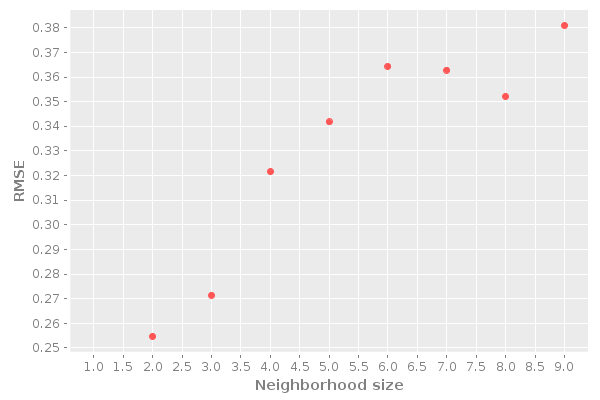

In [22]:
(let [model (load-model "ua.base")
      sim (EuclideanDistanceSimilarity. model)
      ns (range 1 10)
      stats (for [n ns]
                (let [builder (recommender-builder n sim)]
                    (do (println n)
                        (evaluate-rmse builder model))))]
    (-> (c/scatter-plot ns stats
                        :x-label "Neighborhood size"
                        :y-label "RMSE")
        (.createBufferedImage 600 400)))

## More statistics

We can get more stats about the performance of our recommender and decide what's best for our users. The **Information Retrieval statistics (IR stats)** it is like search engine evaluation: a search engine should strive to return as many of the results the user is looking for, without returning useless info. Of course, we use **Precision** and **Recall** to evaluate it.

With Mahout we can calculate it with `GenericRecommenderIRStatsEvaluator` which evaluates the performance for each user. We don't split the data into training and test sets, but it works by removing some users' top-rated items.

In [23]:
(defn evaluate-ir
    [builder model]
    (-> (GenericRecommenderIRStatsEvaluator.)
        (.evaluate builder nil model nil 5
                   GenericRecommenderIRStatsEvaluator/CHOOSE_THRESHOLD
                   1.0)
        (bean)))

#'ch7.nb/evaluate-ir

In [24]:
(let [model (load-model "ua.base")
      builder (recommender-builder
                  10 (EuclideanDistanceSimilarity. model))]
    (evaluate-ir builder model))

{:class org.apache.mahout.cf.taste.impl.eval.IRStatisticsImpl, :f1Measure 0.12227247160987471, :fallOut 0.0026328522573973866, :normalizedDiscountedCumulativeGain 0.1238618931039463, :precision 0.11675126903553307, :reach 1.0, :recall 0.12834179357021985}

The **Discounted Cumulative Gain (DCG)** is a measure of performance for recommendation systems based on the graded relevance of the recommended entities. It is $0<DCG<1$ with $1$ as perfect ranking.

$$
DCG_p=\sum_{i=1}^{p}\frac{2^{rel_i}-1}{log_2(i+1)}
$$

$rel_i$ is the relevance of the result at position $i$ and $p$ is the position in the rank.

But, since the search result lists vary in length depending on the query, we can't compare results using **DCG** alone. We can sort the result by their relevance and calculate **DCG** again. This method will give the best possible cumulative discounted gain, so we call it **Ideal Discounted Cumulative Gain (IDCG)**.

Taking the ratio of the two $nDCG=\frac{DCG}{IDCG}$ we get the normalized discounted cumulative gain.

In [25]:
(defn plot-ir
  [xs stats]
  (-> (c/xy-plot xs (map :recall stats)
                 :x-label "Neighborhood size"
                 :y-label "IR Statistic"
                 :series-label "Recall"
                 :legend true)
      (c/add-lines xs (map :precision stats)
                   :series-label "Precision")
      (c/add-lines xs
                   (map :normalizedDiscountedCumulativeGain stats)
                   :series-label "NDCG")
      (.createBufferedImage 600 400)))

#'ch7.nb/plot-ir

1
2
3
4
5
6
7
8
9


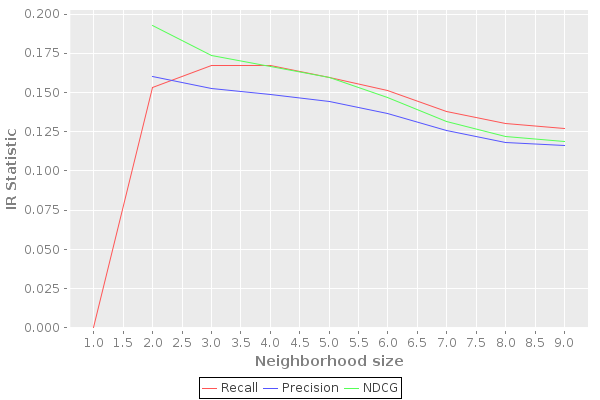

In [26]:
(let [model (load-model "ua.base")
      sim (EuclideanDistanceSimilarity. model)
      xs (range 1 10)
      stats (for [n xs]
              (let [builder (recommender-builder n sim)]
                (do (println n)
                    (evaluate-ir builder model))))]
  (plot-ir xs stats))

## Boolean preferences

We always assumed that the rating a user gives to an item is important. Another way to look at the issue is that the rating isn't so important after all, what we care about is if the user rated it at all. To do it we use **Boolean similarity**.

In [27]:
(defn to-boolean-preferences
  [model]
  (-> (GenericBooleanPrefDataModel/toDataMap model)
      (GenericBooleanPrefDataModel.)))

(defn boolean-recommender-builder [n sim]
  (reify RecommenderBuilder
    (buildRecommender [this model]
      (let [nhood (NearestNUserNeighborhood. n sim model)]
        (GenericBooleanPrefUserBasedRecommender. model nhood sim)))))

#'ch7.nb/boolean-recommender-builder

All of this means we have sets with 0s and 1s, so one way to measure similarity is the **Jaccard index**, but **Mahout** implements the **Tanimoto coefficient** so we will use that one (the two are basically the same: the first one applies to sets that may contain or not elements, while the second compares sets with 1s and 0s).

1
2
3
4
5
6
7
8
9


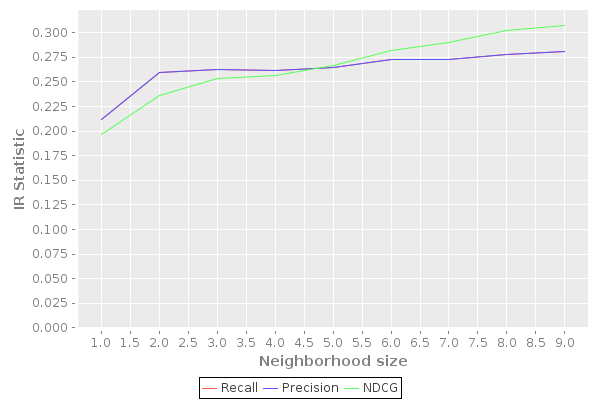

In [28]:
(let [model   (to-boolean-preferences (load-model "ua.base"))
      sim     (TanimotoCoefficientSimilarity. model)
      xs      (range 1 10)
      stats   (for [n xs]
                (let [builder
                      (boolean-recommender-builder n sim)]
                  (do (println n)
                      (evaluate-ir builder model))))]
  (plot-ir xs stats))

## Implicit vs Explicit

Rather than trying to elicit explicit ratings as the *only truth*, we might focus on user activity. By using **implicit** feedback - such as clicks and views - can increase the amount of information to base predictions. But this means the size of the data will increase very quickly, before looking at cluster scale stuff, we might rely on **dimensionality reduction**.

### Bloom filters

A **Bloom filter** is a bit vector, the level of compression is configurable with 2 parameters: *k hash functions* and *m bits*.

In [29]:
(defn hash-function
  [m seed]
  (fn [x]
    (-> (Hashing/murmur3_32 seed)
        (.hashUnencodedChars x)
        (.asInt)
        (mod m))))

(defn hash-functions
  [m k]
  (map (partial hash-function m) (range k)))

(defn indices-fn
  [m k]
  (let [f (apply juxt (hash-functions m k))]
    (fn [x]
      (f x))))

(defn bloom-filter
  [m k]
  {:filter (vec (repeat m false))
   :indices-fn (indices-fn m k)})

#'ch7.nb/bloom-filter

In [30]:
(bloom-filter 8 5)

{:filter [false false false false false false false false], :indices-fn #function[ch7.nb/indices-fn/fn--17581]}

In [31]:
(defn set-bit
  [seq index]
  (assoc seq index true))

(defn set-bits
  [seq indices]
  (reduce set-bit seq indices))

(defn bloom-assoc
  [{:keys [indices-fn] :as bloom} element]
  (update-in bloom [:filter] set-bits (indices-fn element)))

#'ch7.nb/bloom-assoc

In [32]:
(-> (bloom-filter 8 5)
    (bloom-assoc "Indiana Jones")
    :filter)

[true true false true false false false true]

In [33]:
(defn bloom-contains?
  [{:keys [filter indices-fn]} element]
  (->> (indices-fn element)
       (map filter)
       (every? true?)))

#'ch7.nb/bloom-contains?

In [34]:
(-> (bloom-filter 8 5)
    (bloom-assoc "Indiana Jones")
    (bloom-contains? "Indiana Jones"))

true

In [35]:
(-> (bloom-filter 8 5)
    (bloom-assoc "Indiana Jones")
    (bloom-contains? "The Fugitive"))

false

In [36]:
(-> (bloom-filter 8 5)
    (bloom-assoc "Indiana Jones")
    (bloom-contains? "Bogus (1996)"))

true

As we just saw the **Bloom filter** will never say that an item hasn't been added when it has, but it can say that an item is there when it's not. There are 56 titles out of 1682 in the *MovieLens* dataset that the filter incorrectly reports on after adding "Indiana Jones" (3.3% error rate). The probability of obtaining a collision is:

$$
(1-e^{-\frac{kn}{m}})^k
$$

$k$ and $m$ are the parameters of the **Bloom filter** and $n$ is the number of items added to the set. Solving it for our filter gives:

$$
(1-e^{-\frac{5}{8}})^5 \approx 0.022
$$

Although **Bloom filters** are a nice configurable way to compress data, we can't compare their content, so not good for recommendation systems.

### MinHash

With **MinHash** we can compress data and retain the ability to compare sets. Let's check how it works on the 2 most prolific raters of the dataset

In [37]:
(defn rated-items
  [user-ratings id]
  (->> (get user-ratings id)
       (map :item)))

#'ch7.nb/rated-items

In [38]:
(let [ratings (load-ratings "ua.base")
      user-ratings (group-by :user ratings)
      user-a (rated-items user-ratings 405)
      user-b (rated-items user-ratings 655)]
  (println "User 405: " (count user-a))
  (println "User 655: " (count user-b))
  (s/jaccard-index (set user-a) (set user-b)))

User 405:  727
User 655:  675


158/543

With **MinHash** we pick *k* hash functions, but rather than hashing the set representation itself, we hash each element within the set. For each of the hash functions we pick the minimum value generated by any of the elements. So the output is a set of *k* numbers each equals the min hash value for that hash function.

In [39]:
(defn hash-function
  [seed]
  (let [f (Hashing/murmur3_32 seed)]
    (fn [x]
      (-> (.hashUnencodedChars f (str x))
          (.asInt)))))

(defn hash-functions
  [k]
  (map hash-function (range k)))

(defn pairwise-min
  [a b]
  (map min a b))

(defn minhasher
  [k]
  (let [f (apply juxt (hash-functions k))]
    (fn [coll]
      (->> (map f coll)
           (reduce pairwise-min)))))

#'ch7.nb/minhasher

In [40]:
((minhasher 5) [1 2 3 4])

(-1265741853 -623552190 -1570063170 -1810453357 -793765815)

In [41]:
(let [ratings (load-ratings "ua.base")
      user-ratings (group-by :user ratings)
      minhash (minhasher 10)
      user-a (minhash (rated-items user-ratings 405))
      user-b (minhash (rated-items user-ratings 655))]
  (println "User 405: " user-a)
  (println "User 655: " user-b)
  (s/jaccard-index (set user-a) (set user-b)))

User 405:  (-2144897714 -2146662900 -2141119028 -2143110220 -2140441272 -2145866799 -2147145175 -2143703868 -2146421577 -2139426844)
User 655:  (-2144975311 -2146662900 -2141119028 -2141275395 -2145738774 -2140926583 -2147134300 -2143703868 -2146421577 -2147345319)


1/4

### Locality-sensitive hashing

While **MinHasher** helps us saving space and time, it can still be prohibitively intensive. **Locality-sensitive hashing (LSH)** reduces the number of pairwise comparisons that we have to do. It does this by bucketing sets that are likely to have a minimum threshold of similarity together, only these sets need to be checked.

We consider any pair that hash to the same bucket as a candidate for checking. If we computed **MinHash** signatures, an effective way to bucket them is to divide the signature matrix into $b$ bands consisting of $r$ elements as in the picture below:

![buckets](../resources/hash_bucks.png)

Now we just have to produce the **MinHash** signatures as before, and then partition the signature into bands of length $r$.

In [42]:
(def lsh-hasher (hash-function 0))

(defn locality-sensitive-hash
  [r]
  {:r r :bands {}})

(defn buckets-for
  [r signature]
  (->> (partition-all r signature)
       (map lsh-hasher)
       (map-indexed vector)))

(defn lsh-assoc
  [{:keys [r] :as lsh} {:keys [id signature]}]
  (let [f (fn [lsh [band bucket]]
            (update-in lsh [:bands band bucket] conj id))]
    (->> (buckets-for r signature)
         (reduce f lsh))))

#'ch7.nb/lsh-assoc

Here we defined a **LSH** as a map containing empty bands and $r$. When we associate a value into **LSH** with `lsh-assoc` we split the signature into $r$ bands and determine the bucket for each band. The items' IDs are added to buckets and these are grouped by the band ID, in this way items sharing a bucket in different bands are not put together

In [43]:
(clojure.pprint/pprint 
  (let [ratings (load-ratings "ua.base")
        user-ratings (group-by :user ratings)
        minhash (minhasher 27)
        user-a (minhash (rated-items user-ratings 13))
        lsh (locality-sensitive-hash 3)]
    (lsh-assoc lsh {:id 13 :signature user-a})))

{:r 3,
 :bands
 {0 {1353249231 (13)},
  1 {-100016681 (13)},
  2 {-1217282814 (13)},
  3 {-704443054 (13)},
  4 {-143738650 (13)},
  5 {-1809511158 (13)},
  6 {1177598806 (13)},
  7 {-2054093854 (13)},
  8 {220825369 (13)}}}


In the example above we performed **LSH** on user 13 with $k=27$ and $r=3$. We got back the buckets for 9 bands.

In [44]:
(clojure.pprint/pprint
  (let [ratings (load-ratings "ua.base")
        user-ratings (group-by :user ratings)
        minhash (minhasher 27)
        user-a (minhash (rated-items user-ratings 13))
        user-b (minhash (rated-items user-ratings 655))]
    (-> (locality-sensitive-hash 3)
        (lsh-assoc {:id 13 :signature user-a})
        (lsh-assoc {:id 655 :signature user-b}))))

{:r 3,
 :bands
 {0 {1353249231 (13), -780811496 (655)},
  1 {-100016681 (13), -115792260 (655)},
  2 {-1217282814 (13), -1911274538 (655)},
  3 {-704443054 (13), 123070264 (655)},
  4 {-143738650 (13), -154360221 (655)},
  5 {-1809511158 (13), -1272446116 (655)},
  6 {1177598806 (13), 872296818 (655)},
  7 {-2054093854 (13), 1126350710 (655)},
  8 {220825369 (655 13)}}}


So, users 13 and 655 are put together in the bucket for band 8, but in different buckets for the other bands.

The probability that signatures agree for one band is $s^r$, where $s$ is the true similarity of sets and $r$ is the band's $r$. So the probability that signatures don't agree across all bands is $(1-s^r)^b$.

To search for candidate pairs we perform the same process on a target signature and see which other items share the same buckets in the same bands

In [45]:
(defn lsh-candidates
  [{:keys [bands r]} signature]
  (->> (buckets-for r signature)
       (mapcat (fn [[band bucket]]
                 (get-in bands [band bucket])))
       (distinct)))

#'ch7.nb/lsh-candidates

In [46]:
(clojure.pprint/pprint
  (let [ratings (load-ratings "ua.base")
        user-ratings (group-by :user ratings)
        minhash (minhasher 27)
        user-a (minhash (rated-items user-ratings 13))
        user-b (minhash (rated-items user-ratings 655))
        user-c (minhash (rated-items user-ratings 405))]
    (-> (locality-sensitive-hash 3)
        (lsh-assoc {:id 655 :signature user-b})
        (lsh-assoc {:id 405 :signature user-c})
        (lsh-candidates user-a))))

(655)


## Dimensionality reduction

In [47]:
(def iris (iio/read-dataset "data/iris.csv" :header true))

#'ch7.nb/iris

In [48]:
iris


| :sepal_length | :sepal_width | :petal_length | :petal_width |   :species |
|---------------+--------------+---------------+--------------+------------|
|           5.1 |          3.5 |           1.4 |          0.2 |     setosa |
|           4.9 |          3.0 |           1.4 |          0.2 |     setosa |
|           4.7 |          3.2 |           1.3 |          0.2 |     setosa |
|           4.6 |          3.1 |           1.5 |          0.2 |     setosa |
|           5.0 |          3.6 |           1.4 |          0.2 |     setosa |
|           5.4 |          3.9 |           1.7 |          0.4 |     setosa |
|           4.6 |          3.4 |           1.4 |          0.3 |     setosa |
|           5.0 |          3.4 |           1.5 |          0.2 |     setosa |
|           4.4 |          2.9 |           1.4 |          0.2 |     setosa |
|           4.9 |          3.1 |           1.5 |          0.1 |     setosa |
|           5.4 |          3.7 |           1.5 |          0.2 |     setosa 

In [49]:
(defn plot-iris-columns
  [a b]
  (let [data (->> iris
                  (i/$ [a b])
                  (i/to-matrix))]
    (-> (c/scatter-plot (i/$ (range 50) 0 data)
                        (i/$ (range 50) 1 data)
                        :x-label (name a)
                        :y-label (name b))
        (c/add-points (i/$ (range 50 100) 0 data)
                      (i/$ (range 50 100) 1 data))
        (c/add-points (i/$ [:not (range 100)] 0 data)
                      (i/$ [:not (range 100)] 1 data))
        (.createBufferedImage 600 400))))

#'ch7.nb/plot-iris-columns

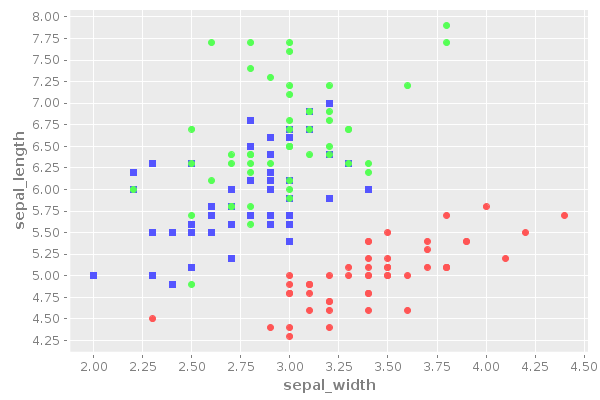

In [50]:
(plot-iris-columns :sepal_width
                   :sepal_length)

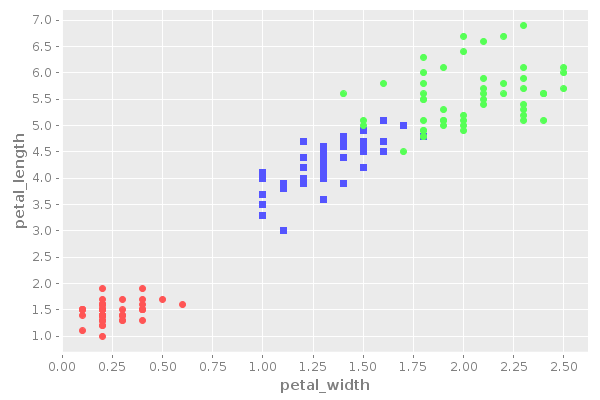

In [51]:
(plot-iris-columns :petal_width
                   :petal_length)

### PCA

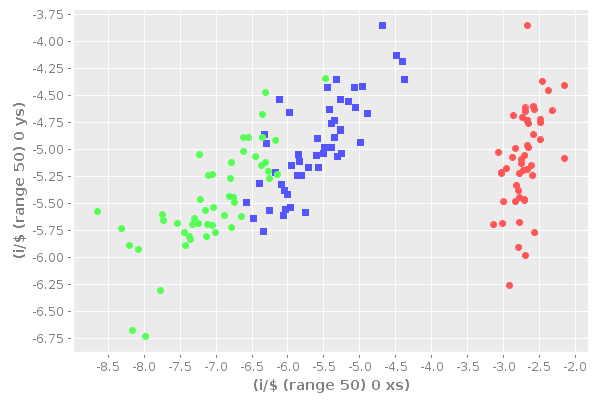

In [52]:
(let [data (->> iris
                (i/$ (range 4))
                (i/to-matrix))
      components (s/principal-components data)
      pc1 (i/$ 0 (:rotation components))
      pc2 (i/$ 1 (:rotation components))
      xs (i/mmult data pc1)
      ys (i/mmult data pc2)]
  (-> (c/scatter-plot (i/$ (range 50) 0 xs)
                      (i/$ (range 50) 0 ys))
      (c/add-points (i/$ (range 50 100) 0 xs)
                    (i/$ (range 50 100) 0 ys))
      (c/add-points (i/$ [:not (range 100)] 0 xs)
                    (i/$ [:not (range 100)] 0 ys))
      (.createBufferedImage 600 400)))

## SVD

In [53]:
(defn project-into
  [matrix d]
  (let [svd (i/decomp-svd matrix)]
    {:U (i/$ (range d) (:U svd))
     :S (i/diag (take d (:S svd)))
     :V (i/trans
          (i/$ (range d) (:V svd)))}))

#'ch7.nb/project-into

In [54]:
(let [matrix (s/sample-mvn 100
                           :sigma (i/matrix [[1 0.8]
                                             [0.8 1]]))]
  (println "Original" matrix)
  (project-into matrix 1))

Original  A 100x2 matrix
 ---------------
-4.75e-01 -9.62e-01 
-6.97e-01 -1.38e+00 
-8.87e-01 -4.01e-01 
 ... 
-1.76e+00 -2.41e+00 
 3.66e-01  1.61e-01 
 1.83e-01 -7.48e-02 



{:U  A 100x1 matrix
 ---------------
-7.00e-02 
-1.01e-01 
-6.32e-02 
 ... 
-2.03e-01 
 2.59e-02 
 5.44e-03 
, :S  A 1x1 matrix
 -------------
 1.45e+01 
, :V  A 1x2 matrix
 -------------
 7.14e-01  7.00e-01 
}

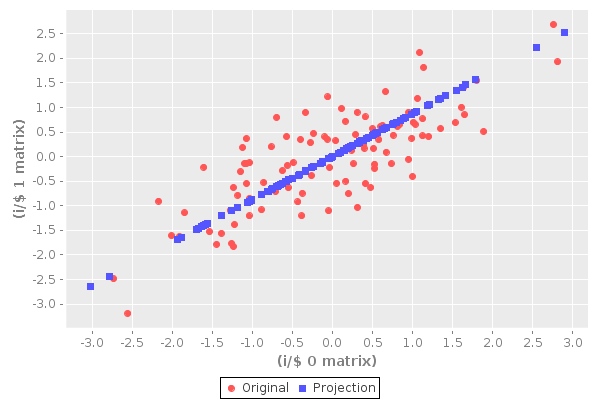

In [55]:
(let [matrix (s/sample-mvn 100
                           :sigma (i/matrix [[1 0.8]
                                             [0.8 1]]))
      svd (project-into matrix 1)
      projection (i/mmult (:U svd)
                          (:S svd)
                          (:V svd))]
  (-> (c/scatter-plot (i/$ 0 matrix) (i/$ 1 matrix)
                      :series-label "Original"
                      :legend true)
      (c/add-points (i/$ 0 projection) (i/$ 1 projection)
                    :series-label "Projection")
      (.createBufferedImage 600 400)))

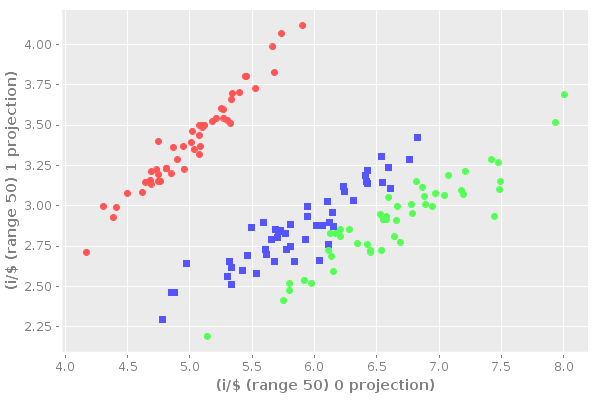

In [57]:
(let [svd (->> iris
               (i/$ (range 4))
               (i/to-matrix)
               (i/decomp-svd))
      dims 2
      u (i/$ (range dims) (:U svd))
      s (i/diag (take dims (:S svd)))
      v (i/trans (i/$ (range dims) (:V svd)))
      projection (i/mmult u s v)]
  (-> (c/scatter-plot (i/$ (range 50) 0 projection)
                      (i/$ (range 50) 1 projection))
      (c/add-points (i/$ (range 50 100) 0 projection)
                    (i/$ (range 50 100) 1 projection))
      (c/add-points (i/$ [:not (range 100)] 0 projection)
                    (i/$ [:not (range 100)] 1 projection))
      (.createBufferedImage 600 400)))

# Spark

We will use **[Sparkling](https://gorillalabs.github.io/sparkling/)** to communicate with **Spark**, but there is also **[Flambo](https://github.com/yieldbot/flambo)**. We don't have to have HDFS, we can load data from any storage source, even the file system.

Let's start by counting the number of ratings in the **MovieLens** dataset.

In [3]:
(defn count-ratings
  [sc]
  (-> (spark/text-file sc "data/ml-100k/ua.base")
      (spark/count)))

#'ch7.nb/count-ratings

In [4]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (count-ratings sc))

90570

First of all we have to pass a **Spark** context as the first argument, which tells **Spark** how to access the cluster. The most basic conf gives **Spark** the location of its master and the app name. Since we are running it locally, we pass `"local"` as master.

For simplicity we will parse each rating into a `Rating` object.

In [5]:
(defn parse-long [i]
  (Long/parseLong i))

(defn parse-rating
  [line]
  (let [[user item rating time] (->> (str/split line #"\t")
                                     (map parse-long))]
    (spark/tuple (mod time 10)
                 (Rating. user item rating))))

(defn parse-ratings
  [sc]
  (->> (spark/text-file sc "data/ml-100k/ua.base")
       (spark/map-to-pair parse-rating)))

#'ch7.nb/parse-ratings

In [6]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (->> (parse-ratings sc)
       (spark/collect)
       first))

#sparkling/tuple [8 #object[org.apache.spark.mllib.recommendation.Rating 0x76f26d64 "Rating(1,1,5.0)"]]

**Spark** uses tuples to represent pairs of keys and values, while datasets are represented as **RDDs**. Let's now filter the data based on the key and create a subset that can be used for training.

In [7]:
(defn training-ratings
  [ratings]
  (->> ratings
       (spark/filter (fn [tuple]
                       (< (s-de/key tuple) 8)))
       (spark/values)))

(defn test-ratings [ratings]
  (->> ratings
       (spark/filter (s-de/first-value-fn
                      (fn [key] (>= key 8))))
       (spark/values)))

#'ch7.nb/test-ratings

**Spark** much like Clojure is lazy and won't calculate values unless they are needed, and similarly it won't explicitly cache data by default. Of course we can persist **RDDs**, and we can choose whether to store them in-memory, on disk or even replicate the cache across disks. In this case we will store the data in-memory

In [8]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (let [ratings (spark/cache (parse-ratings sc))
        train (training-ratings ratings)
        test (test-ratings ratings)]
    (println "Training: " (spark/count train))
    (println "Test:     " (spark/count test))))

Training:  72814
Test:      17756


## ALS with MLlib

**Alternating least squares (ALS)** is an iterative algo that uses least-squares estimates to decompose the *user-movies* matrix into 2 matrices: the **user factors** and **movie factors**. We're assuming that users' ratings are based on some latent property of the movie that can't be measured directly, but can be inferred from the ratings matrix.

So we're basically reducing dimensionality and the prediction problem is reduced as well: it is a matrix multiplication.

In [9]:
(defn to-mllib-rdd
  [rdd]
  (.rdd rdd))

(defn from-mllib-rdd
  [rdd]
  (JavaRDD/fromRDD rdd scala/OBJECT-CLASS-TAG))

(defn als
  [data {:keys [rank num-iter lambda]}]
  (ALS/train (to-mllib-rdd data) rank num-iter lambda 10))

#'ch7.nb/als

In [10]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (let [options {:rank 10
                 :num-iter 10
                 :lambda 1.0}
        model (-> (parse-ratings sc)
                  (training-ratings)
                  (als options))]
    (into [] (.recommendProducts model 1 3))))

[#object[org.apache.spark.mllib.recommendation.Rating 0x23f2f9fd "Rating(1,814,3.81159854430977)"] #object[org.apache.spark.mllib.recommendation.Rating 0x44bbfae2 "Rating(1,1500,3.74081280560414)"] #object[org.apache.spark.mllib.recommendation.Rating 0x7ff77a09 "Rating(1,1599,3.722143927082771)"]]

In [13]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (let [items (load-items "u.item")
        id->name (fn [id] (get items id))
        options {:rank 10
                 :num-iter 10
                 :lambda 1.0}
        model (-> (parse-ratings sc)
                  (training-ratings)
                  (als options))]
    (->> (.recommendProducts model 1 3) ; recommendations for one user
         (map (comp id->name #(.product %))))))

("Great Day in Harlem, A (1994)" "Santa with Muscles (1996)" "Someone Else's America (1995)")

Now we want to evaluate **ALS**, unfortunately **Spark** doesn't have a builtin evaluator, but we have to build our own. We will use RMSE

In [17]:
(defn user-product
  [rating]
  (spark/tuple (.user rating)
               (.product rating)))

(defn user-product-rating
  [rating]
  (spark/tuple (user-product rating)
               (.rating rating)))

(defn predict
  [model data]
  (->> (spark/map-to-pair user-product data)
       (to-mllib-rdd)
       (.predict model) ; predicts many users and items at once
       (from-mllib-rdd)
       (spark/map-to-pair user-product-rating)))

#'ch7.nb/predict

In [18]:
(defn squared-error
  [y-hat y]
  (Math/pow (- y-hat y) 2))

(defn sum-squared-errors
  [predictions actuals]
  (->> (spark/join predictions actuals)
       (spark/values)
       (spark/map (s-de/val-val-fn squared-error))
       (spark/reduce +)))

(defn rmse
  [model data]
  (let [predictions (spark/cache (predict model data))
        actuals (->> (spark/map-to-pair user-product-rating
                                        data)
                     (spark/cache))]
    (-> (sum-squared-errors predictions actuals)
        (/ (spark/count data))
        (Math/sqrt))))

#'ch7.nb/rmse

Previously we plotted RMSE as the size of the neighborhood increased, now we will do the same altering the rank of the factor matrix

0.8603952094417379 RMSE for rank  2
0.8117099384165897 RMSE for rank  4
0.7768904449694453 RMSE for rank  6
0.7525064628253808 RMSE for rank  8
0.7292207636398794 RMSE for rank  10
0.7107159531880162 RMSE for rank  12
0.6939301310734743 RMSE for rank  14
0.6827977515623589 RMSE for rank  16
0.6704441695024634 RMSE for rank  18
0.6601894169327599 RMSE for rank  20
0.6507801848555987 RMSE for rank  22
0.6434828436909502 RMSE for rank  24
0.6358466787746468 RMSE for rank  26
0.6300949414660368 RMSE for rank  28
0.6246893907614376 RMSE for rank  30
0.6210775178670175 RMSE for rank  32
0.6176178282971851 RMSE for rank  34
0.6134024431990618 RMSE for rank  36
0.6096659785557145 RMSE for rank  38
0.6074819227609093 RMSE for rank  40
0.6048177113075409 RMSE for rank  42
0.6025346845758524 RMSE for rank  44
0.6011585873277333 RMSE for rank  46
0.5989041090254821 RMSE for rank  48


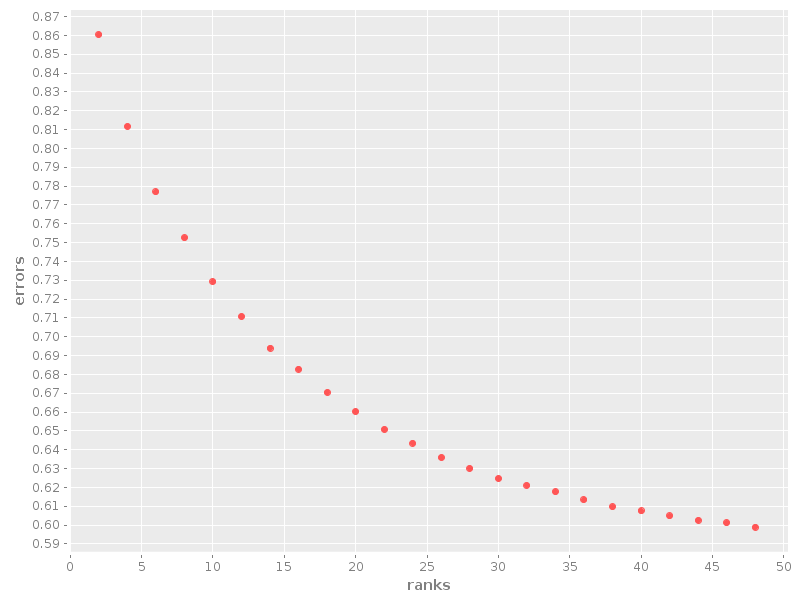

In [19]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
  (let [options {:num-iter 10 :lambda 0.1}
        training (-> (parse-ratings sc)
                     (training-ratings)
                     (spark/cache))
        ranks (range 2 50 2)
        errors (for [rank ranks]
                 (doto (-> (als training
                                (assoc options :rank rank))
                           (rmse training))
                   (println "RMSE for rank " rank)))]
    (-> (c/scatter-plot ranks errors)
        (.createBufferedImage 800 600))))

As we can see the higher the rank the better our model performs. But what we really want to do is to evaluate it against test data

0.9338170985068125 RMSE for rank 2
0.9276708507425292 RMSE for rank 4
0.9322441482267607 RMSE for rank 6
0.9296980546516551 RMSE for rank 8
0.9322518932140851 RMSE for rank 10
0.9342636990221903 RMSE for rank 12
0.932053593266065 RMSE for rank 14
0.9304577739156324 RMSE for rank 16
0.9308966272594319 RMSE for rank 18
0.930384359299621 RMSE for rank 20
0.9284217282982595 RMSE for rank 22
0.929581608323128 RMSE for rank 24
0.928247493914443 RMSE for rank 26
0.9287968254411585 RMSE for rank 28
0.9255370813852937 RMSE for rank 30
0.9255798554173209 RMSE for rank 32
0.9273954517221189 RMSE for rank 34
0.9267639491230251 RMSE for rank 36
0.9287317995492522 RMSE for rank 38
0.925299060384896 RMSE for rank 40
0.9260601972192902 RMSE for rank 42
0.9249536745200022 RMSE for rank 44
0.9256885301855277 RMSE for rank 46
0.9250079042815441 RMSE for rank 48


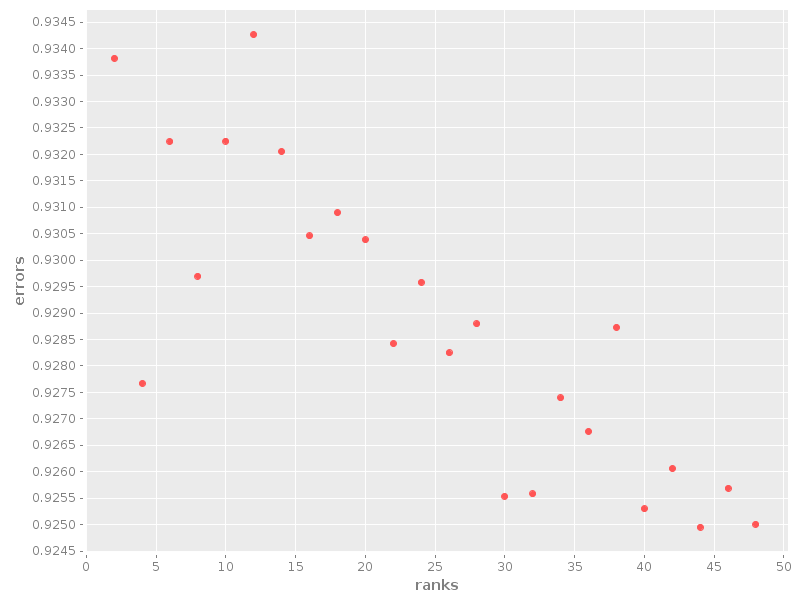

In [21]:
(spark/with-context sc (-> (conf/spark-conf)
                           (conf/master "local")
                           (conf/app-name "ch7"))
   (let [options {:num-iter 10 :lambda 0.1}
          parsed   (spark/cache (parse-ratings sc))
          training (spark/cache (training-ratings parsed))
          test     (spark/cache (test-ratings parsed))
          ranks    (range 2 50 2)
          errors   (for [rank ranks]
                     (doto (-> (als training
                                  (assoc options :rank rank))
                               (rmse test))
                       (println "RMSE for rank" rank)))]
    (-> (c/scatter-plot ranks errors)
        (.createBufferedImage 800 600))))